In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
DATA_DIR = "/kaggle/input/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


In [ ]:
def print_class_distribution(folder, split_name):
    dataset = datasets.ImageFolder(folder)
    counts = Counter(dataset.targets)
    print(f"\n{split_name} distribution:")
    for idx, cls in enumerate(dataset.classes):
        print(f"{cls}: {counts[idx]}")

print_class_distribution(TRAIN_DIR, "Train")
print_class_distribution(VAL_DIR, "Validation")
print_class_distribution(TEST_DIR, "Test")



Train distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 195
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 115
normal: 148
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 155

Validation distribution:
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib: 23
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa: 21
normal: 13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa: 15

Test distribution:
adenocarcinoma: 120
large.cell.carcinoma: 51
normal: 54
squamous.cell.carcinoma: 90


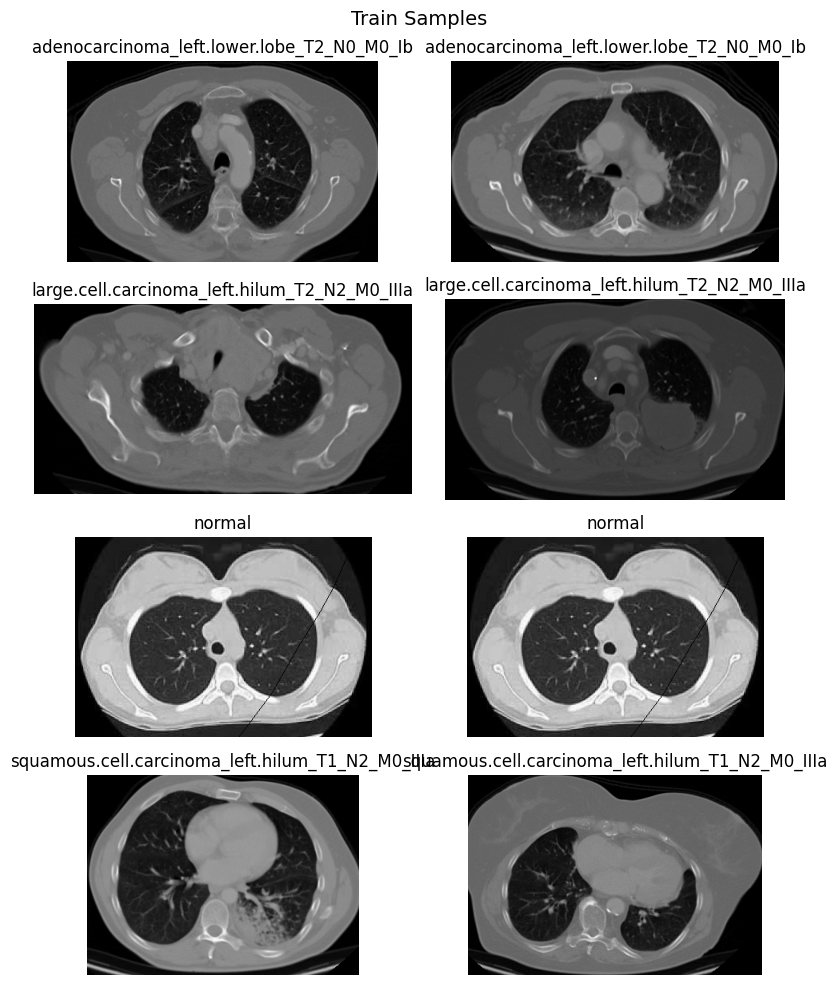

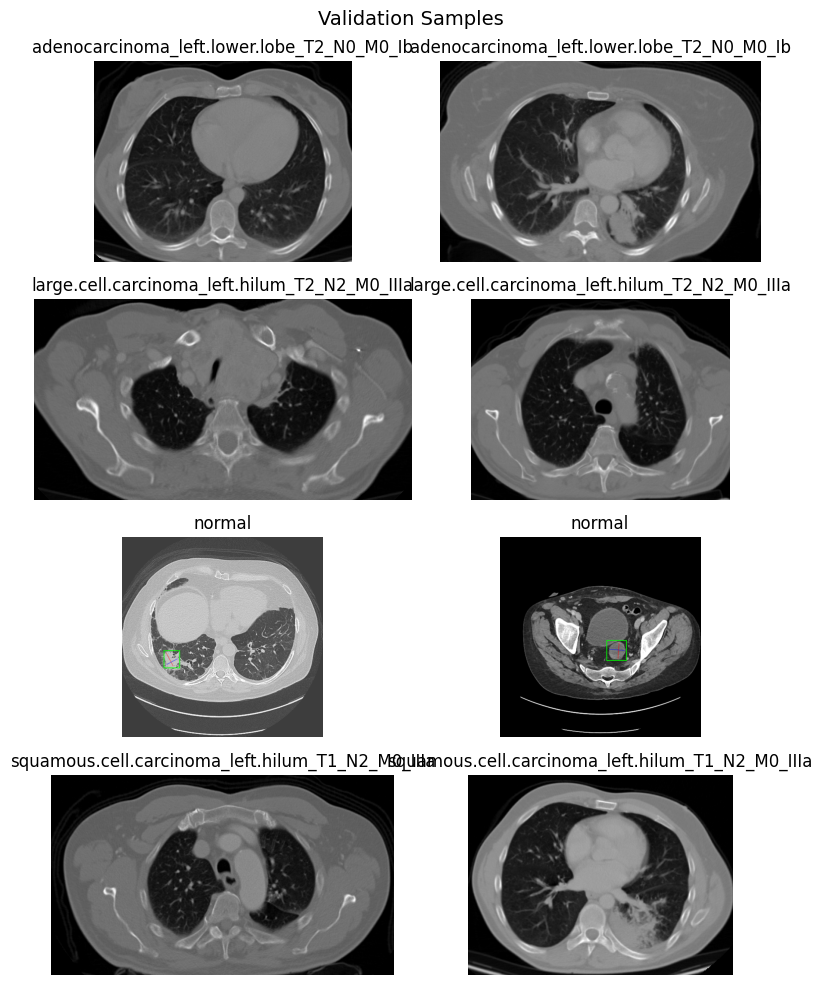

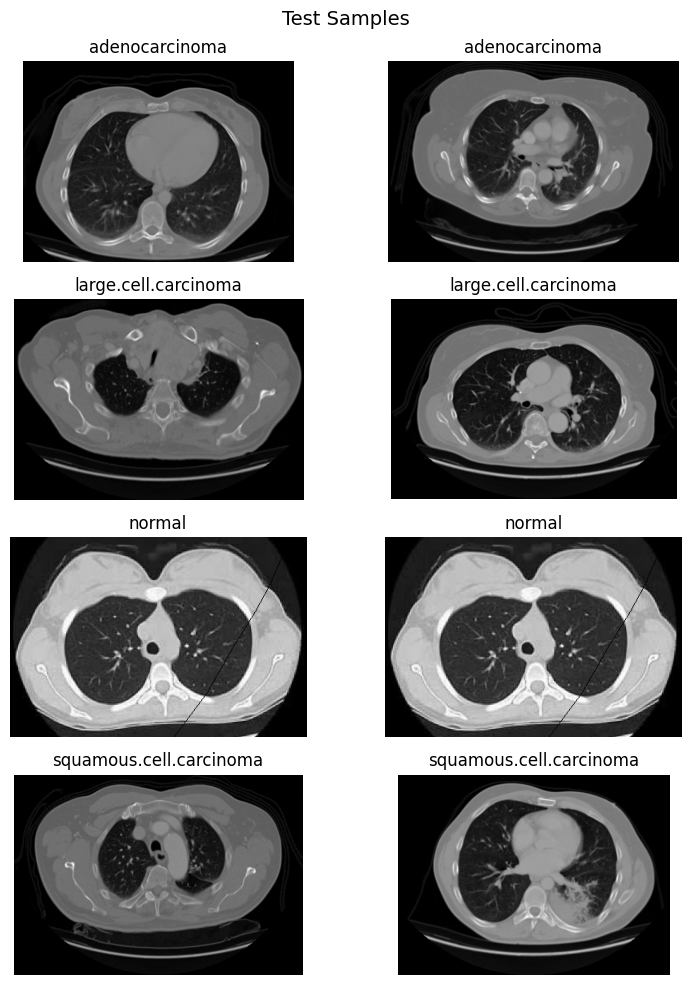

In [ ]:
def show_images(folder, title, n_per_class=2):
    dataset = datasets.ImageFolder(folder)
    class_indices = {i: [] for i in range(len(dataset.classes))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < n_per_class:
            class_indices[label].append(idx)

    images = []
    labels = []

    for label, idxs in class_indices.items():
        for idx in idxs:
            img, lbl = dataset[idx]
            images.append(img)
            labels.append(dataset.classes[lbl])

    fig, axes = plt.subplots(len(dataset.classes), n_per_class, figsize=(8, 10))
    fig.suptitle(title, fontsize=14)

    for i in range(len(images)):
        ax = axes[i // n_per_class, i % n_per_class]
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images(TRAIN_DIR, "Train Samples")
show_images(VAL_DIR, "Validation Samples")
show_images(TEST_DIR, "Test Samples")


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [ ]:
from torchvision import models
import torch.nn as nn

model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Replace classifier
model.classifier[1] = nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 160MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4
)


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    matthews_corrcoef
)

from tqdm import tqdm


In [ ]:
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    metrics = {}

    metrics["accuracy"] = accuracy_score(y_true, y_pred)
    metrics["precision"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["f1"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    metrics["mcc"] = matthews_corrcoef(y_true, y_pred)

    # Sensitivity = Recall
    metrics["sensitivity"] = metrics["recall"]

    # Specificity (macro)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp + 1e-8))
    metrics["specificity"] = np.mean(specificity)

    # AUC
    try:
        metrics["auc"] = roc_auc_score(
            y_true, y_prob, multi_class="ovr"
        )
    except:
        metrics["auc"] = 0.0

    return metrics


In [ ]:
def run_epoch(model, loader, criterion, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    loop = tqdm(loader)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    avg_loss = total_loss / len(loader)
    return avg_loss, np.array(all_labels), np.array(all_preds), np.array(all_probs)


In [ ]:
EPOCHS = 30
PATIENCE = 5

history = {
    "train": {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]},
    "val":   {k: [] for k in ["loss","accuracy","precision","recall","f1","specificity","sensitivity","mcc","auc"]}
}

best_val_loss = float("inf")
patience_counter = 0

for epoch in range(EPOCHS):


    train_loss, y_t, y_p, y_prob = run_epoch(
        model, train_loader, criterion, optimizer, train=True
    )
    train_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    train_metrics["loss"] = train_loss


    val_loss, y_t, y_p, y_prob = run_epoch(
        model, val_loader, criterion, train=False
    )
    val_metrics = compute_metrics(y_t, y_p, y_prob, NUM_CLASSES)
    val_metrics["loss"] = val_loss


    for k in history["train"]:
        history["train"][k].append(train_metrics[k])
        history["val"][k].append(val_metrics[k])


    print(f"\nTraining Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Train Metrics - loss: {train_metrics['loss']:.4f}, "
        f"accuracy: {train_metrics['accuracy']:.4f}, "
        f"precision: {train_metrics['precision']:.4f}, "
        f"recall: {train_metrics['recall']:.4f}, "
        f"f1_score: {train_metrics['f1']:.4f}, "
        f"specificity: {train_metrics['specificity']:.4f}, "
        f"sensitivity: {train_metrics['sensitivity']:.4f}, "
        f"mcc: {train_metrics['mcc']:.4f}, "
        f"auc: {train_metrics['auc']:.4f}"
    )

    print(f"Validating Model - Epoch [{epoch+1}/{EPOCHS}]")
    print(
        f"Val Metrics   - loss: {val_metrics['loss']:.4f}, "
        f"accuracy: {val_metrics['accuracy']:.4f}, "
        f"precision: {val_metrics['precision']:.4f}, "
        f"recall: {val_metrics['recall']:.4f}, "
        f"f1_score: {val_metrics['f1']:.4f}, "
        f"specificity: {val_metrics['specificity']:.4f}, "
        f"sensitivity: {val_metrics['sensitivity']:.4f}, "
        f"mcc: {val_metrics['mcc']:.4f}, "
        f"auc: {val_metrics['auc']:.4f}"
    )

    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("\nEarly stopping triggered")
            break


100%|██████████| 5/5 [00:00<00:00, 12.14it/s]



Training Model - Epoch [1/30]
Train Metrics - loss: 0.8563, accuracy: 0.6639, precision: 0.6601, recall: 0.6482, f1_score: 0.6406, specificity: 0.8849, sensitivity: 0.6482, mcc: 0.5487, auc: 0.8652
Validating Model - Epoch [1/30]
Val Metrics   - loss: 0.7901, accuracy: 0.6667, precision: 0.7382, recall: 0.6893, f1_score: 0.6887, specificity: 0.8856, sensitivity: 0.6893, mcc: 0.5685, auc: 0.9044


100%|██████████| 5/5 [00:00<00:00, 12.49it/s]



Training Model - Epoch [2/30]
Train Metrics - loss: 0.2946, accuracy: 0.9233, precision: 0.9268, recall: 0.9221, f1_score: 0.9239, specificity: 0.9735, sensitivity: 0.9221, mcc: 0.8968, auc: 0.9895
Validating Model - Epoch [2/30]
Val Metrics   - loss: 0.4596, accuracy: 0.8056, precision: 0.8355, recall: 0.8222, f1_score: 0.8158, specificity: 0.9354, sensitivity: 0.8222, mcc: 0.7481, auc: 0.9624


100%|██████████| 5/5 [00:00<00:00, 12.40it/s]



Training Model - Epoch [3/30]
Train Metrics - loss: 0.1068, accuracy: 0.9772, precision: 0.9786, recall: 0.9759, f1_score: 0.9772, specificity: 0.9921, sensitivity: 0.9759, mcc: 0.9692, auc: 0.9987
Validating Model - Epoch [3/30]
Val Metrics   - loss: 0.4532, accuracy: 0.8194, precision: 0.8490, recall: 0.8300, f1_score: 0.8284, specificity: 0.9389, sensitivity: 0.8300, mcc: 0.7627, auc: 0.9683


100%|██████████| 5/5 [00:00<00:00, 13.40it/s]



Training Model - Epoch [4/30]
Train Metrics - loss: 0.0623, accuracy: 0.9951, precision: 0.9949, recall: 0.9952, f1_score: 0.9950, specificity: 0.9984, sensitivity: 0.9952, mcc: 0.9934, auc: 0.9993
Validating Model - Epoch [4/30]
Val Metrics   - loss: 0.2999, accuracy: 0.9167, precision: 0.9265, recall: 0.9223, f1_score: 0.9183, specificity: 0.9723, sensitivity: 0.9223, mcc: 0.8913, auc: 0.9823


100%|██████████| 5/5 [00:00<00:00, 12.88it/s]



Training Model - Epoch [5/30]
Train Metrics - loss: 0.0319, accuracy: 0.9967, precision: 0.9962, recall: 0.9968, f1_score: 0.9965, specificity: 0.9990, sensitivity: 0.9968, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [5/30]
Val Metrics   - loss: 0.2889, accuracy: 0.8889, precision: 0.9022, recall: 0.8922, f1_score: 0.8911, specificity: 0.9622, sensitivity: 0.8922, mcc: 0.8528, auc: 0.9870


100%|██████████| 5/5 [00:00<00:00, 13.54it/s]



Training Model - Epoch [6/30]
Train Metrics - loss: 0.0292, accuracy: 0.9935, precision: 0.9930, recall: 0.9936, f1_score: 0.9933, specificity: 0.9979, sensitivity: 0.9936, mcc: 0.9912, auc: 0.9999
Validating Model - Epoch [6/30]
Val Metrics   - loss: 0.4013, accuracy: 0.8472, precision: 0.8684, recall: 0.8601, f1_score: 0.8545, specificity: 0.9491, sensitivity: 0.8601, mcc: 0.8006, auc: 0.9806


100%|██████████| 5/5 [00:00<00:00, 13.53it/s]



Training Model - Epoch [7/30]
Train Metrics - loss: 0.0375, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9967, sensitivity: 0.9902, mcc: 0.9868, auc: 0.9999
Validating Model - Epoch [7/30]
Val Metrics   - loss: 0.4630, accuracy: 0.8611, precision: 0.8816, recall: 0.8788, f1_score: 0.8700, specificity: 0.9542, sensitivity: 0.8788, mcc: 0.8207, auc: 0.9728


100%|██████████| 5/5 [00:00<00:00, 12.95it/s]



Training Model - Epoch [8/30]
Train Metrics - loss: 0.0581, accuracy: 0.9869, precision: 0.9869, recall: 0.9863, f1_score: 0.9866, specificity: 0.9956, sensitivity: 0.9863, mcc: 0.9824, auc: 0.9991
Validating Model - Epoch [8/30]
Val Metrics   - loss: 0.3330, accuracy: 0.8889, precision: 0.9030, recall: 0.9021, f1_score: 0.8955, specificity: 0.9628, sensitivity: 0.9021, mcc: 0.8548, auc: 0.9812


100%|██████████| 5/5 [00:00<00:00, 12.90it/s]



Training Model - Epoch [9/30]
Train Metrics - loss: 0.0413, accuracy: 0.9837, precision: 0.9850, recall: 0.9835, f1_score: 0.9842, specificity: 0.9943, sensitivity: 0.9835, mcc: 0.9780, auc: 0.9997
Validating Model - Epoch [9/30]
Val Metrics   - loss: 0.4089, accuracy: 0.8611, precision: 0.8874, recall: 0.8709, f1_score: 0.8658, specificity: 0.9547, sensitivity: 0.8709, mcc: 0.8224, auc: 0.9838


100%|██████████| 5/5 [00:00<00:00, 13.00it/s]



Training Model - Epoch [10/30]
Train Metrics - loss: 0.0322, accuracy: 0.9886, precision: 0.9883, recall: 0.9900, f1_score: 0.9891, specificity: 0.9962, sensitivity: 0.9900, mcc: 0.9846, auc: 0.9997
Validating Model - Epoch [10/30]
Val Metrics   - loss: 0.2627, accuracy: 0.8750, precision: 0.8870, recall: 0.8886, f1_score: 0.8816, specificity: 0.9581, sensitivity: 0.8886, mcc: 0.8353, auc: 0.9923


100%|██████████| 5/5 [00:00<00:00, 12.16it/s]



Training Model - Epoch [11/30]
Train Metrics - loss: 0.0591, accuracy: 0.9869, precision: 0.9867, recall: 0.9868, f1_score: 0.9867, specificity: 0.9956, sensitivity: 0.9868, mcc: 0.9824, auc: 0.9996
Validating Model - Epoch [11/30]
Val Metrics   - loss: 0.3701, accuracy: 0.8611, precision: 0.8876, recall: 0.8651, f1_score: 0.8671, specificity: 0.9518, sensitivity: 0.8651, mcc: 0.8183, auc: 0.9864


100%|██████████| 5/5 [00:00<00:00, 12.03it/s]



Training Model - Epoch [12/30]
Train Metrics - loss: 0.0682, accuracy: 0.9723, precision: 0.9726, recall: 0.9743, f1_score: 0.9734, specificity: 0.9906, sensitivity: 0.9743, mcc: 0.9626, auc: 0.9990
Validating Model - Epoch [12/30]
Val Metrics   - loss: 0.4148, accuracy: 0.8750, precision: 0.9011, recall: 0.8939, f1_score: 0.8818, specificity: 0.9569, sensitivity: 0.8939, mcc: 0.8416, auc: 0.9788


100%|██████████| 5/5 [00:00<00:00, 12.27it/s]



Training Model - Epoch [13/30]
Train Metrics - loss: 0.0563, accuracy: 0.9821, precision: 0.9835, recall: 0.9810, f1_score: 0.9822, specificity: 0.9938, sensitivity: 0.9810, mcc: 0.9758, auc: 0.9995
Validating Model - Epoch [13/30]
Val Metrics   - loss: 0.3467, accuracy: 0.8889, precision: 0.9075, recall: 0.8985, f1_score: 0.8918, specificity: 0.9628, sensitivity: 0.8985, mcc: 0.8573, auc: 0.9868


100%|██████████| 5/5 [00:00<00:00, 12.49it/s]



Training Model - Epoch [14/30]
Train Metrics - loss: 0.0459, accuracy: 0.9837, precision: 0.9839, recall: 0.9836, f1_score: 0.9837, specificity: 0.9944, sensitivity: 0.9836, mcc: 0.9780, auc: 0.9997
Validating Model - Epoch [14/30]
Val Metrics   - loss: 0.3960, accuracy: 0.8889, precision: 0.9080, recall: 0.9089, f1_score: 0.8973, specificity: 0.9642, sensitivity: 0.9089, mcc: 0.8593, auc: 0.9822


100%|██████████| 5/5 [00:00<00:00, 11.50it/s]


Training Model - Epoch [15/30]
Train Metrics - loss: 0.0148, accuracy: 0.9967, precision: 0.9962, recall: 0.9962, f1_score: 0.9962, specificity: 0.9990, sensitivity: 0.9962, mcc: 0.9956, auc: 1.0000
Validating Model - Epoch [15/30]
Val Metrics   - loss: 0.3083, accuracy: 0.9028, precision: 0.9125, recall: 0.9140, f1_score: 0.9078, specificity: 0.9679, sensitivity: 0.9140, mcc: 0.8725, auc: 0.9875

Early stopping triggered


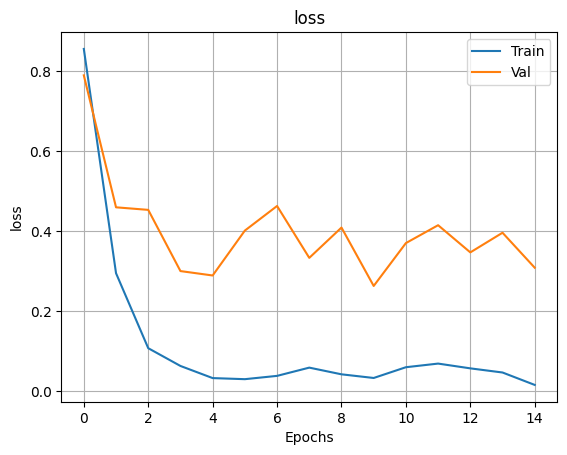

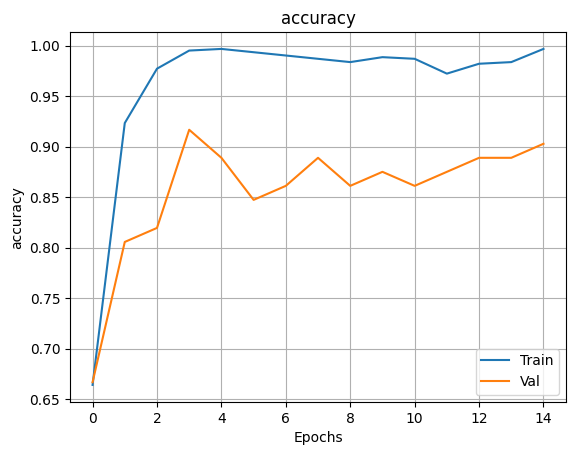

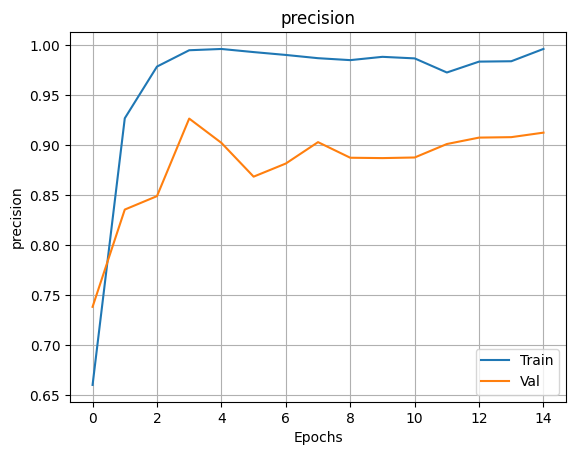

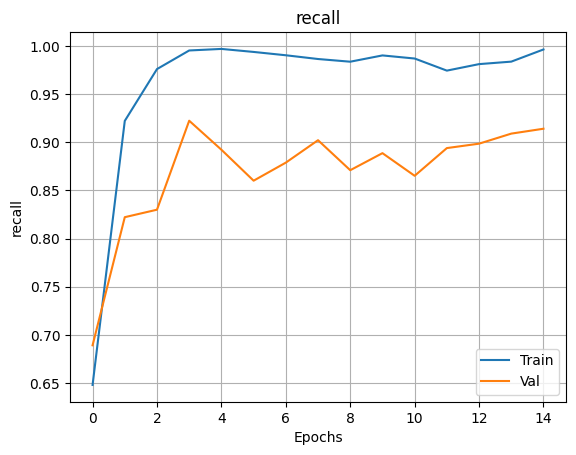

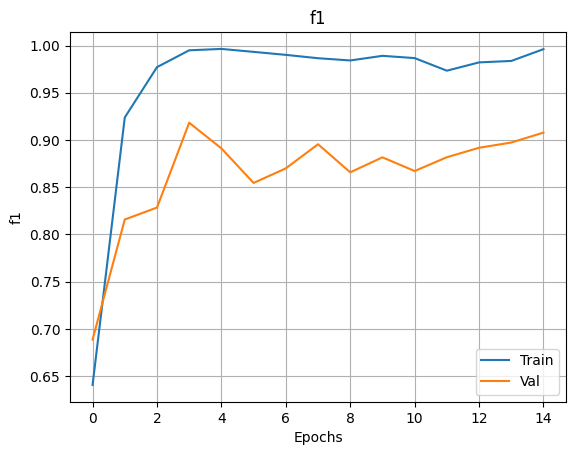

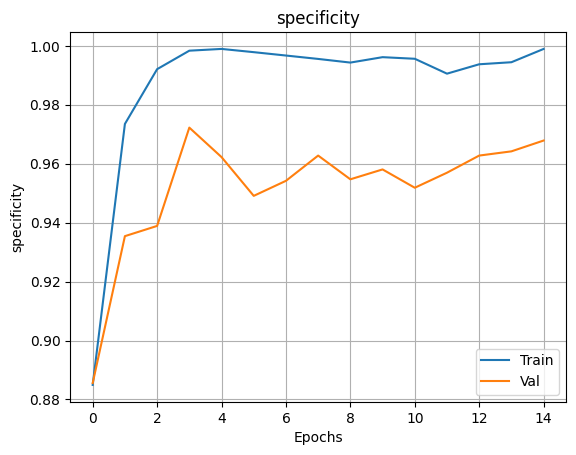

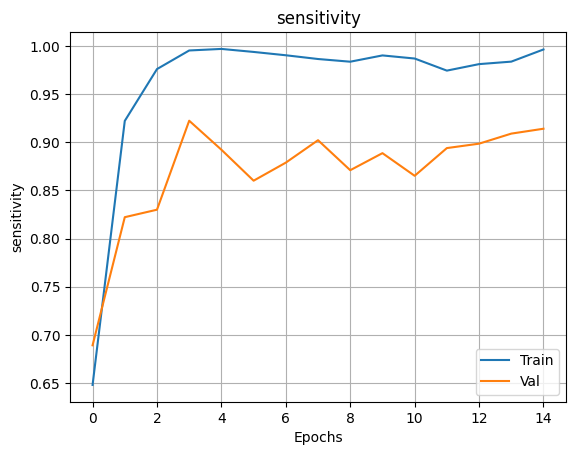

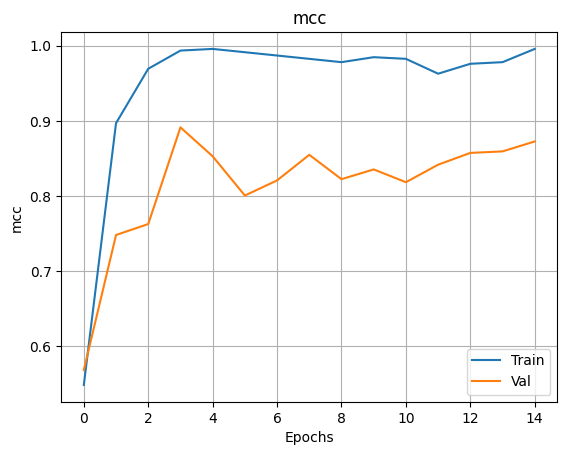

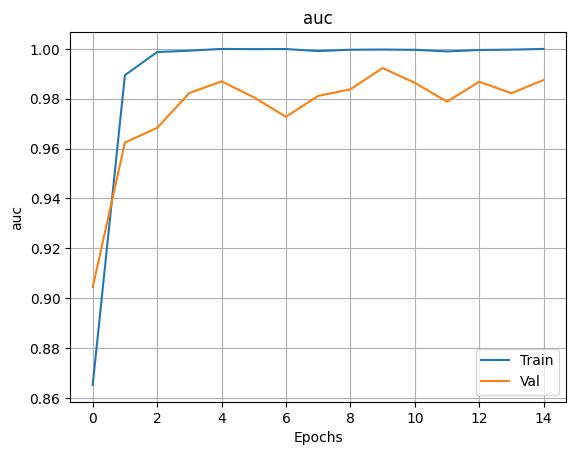

In [ ]:
def plot_metric(metric):
    plt.figure()
    plt.plot(history["train"][metric], label="Train")
    plt.plot(history["val"][metric], label="Val")
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

metrics_to_plot = [
    "loss","accuracy","precision","recall","f1",
    "specificity","sensitivity","mcc","auc"
]

for m in metrics_to_plot:
    plot_metric(m)


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_ds.classes,digits=4))



Confusion Matrix:
 [[109   4   0   7]
 [  1  49   0   1]
 [  0   0  54   0]
 [  8   2   0  80]]

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib     0.9237    0.9083    0.9160       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa     0.8909    0.9608    0.9245        51
                                          normal     1.0000    1.0000    1.0000        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa     0.9091    0.8889    0.8989        90

                                        accuracy                         0.9270       315
                                       macro avg     0.9309    0.9395    0.9348       315
                                    weighted avg     0.9273    0.9270    0.9269       315



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Counts)")
    plt.tight_layout()
    plt.show()


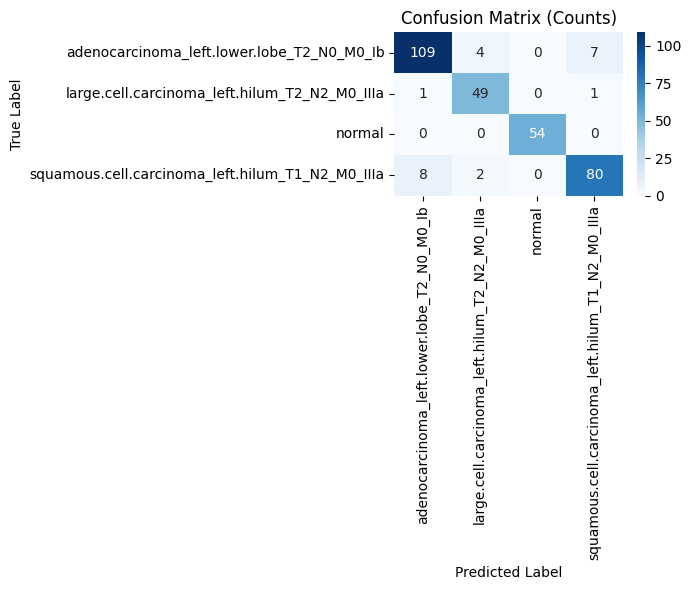

In [ ]:
plot_confusion_matrix(y_true, y_pred, train_ds.classes)


In [ ]:
from sklearn.preprocessing import label_binarize

model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

num_classes = y_prob.shape[1]
class_names = train_ds.classes


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_ovr(y_true, y_prob, class_names):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(8, 6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()


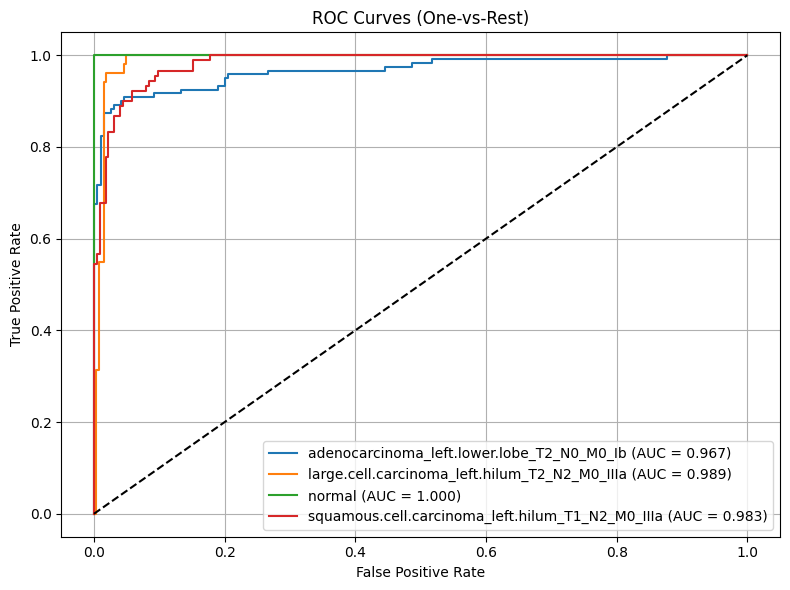

In [ ]:
plot_roc_ovr(y_true, y_prob, train_ds.classes)
